In [1]:
import os
import shutil
os.chdir('..')

import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import seaborn as sns

sns.set_context("notebook", font_scale=1.4)
cmap = sns.diverging_palette(220, 10, as_cmap=True)

tmp_dir = "tmp_dir"
os.makedirs(tmp_dir, exist_ok=True)

# Evaluation

* The goal of this notebook is to provide an end-to-end example for evaluating recommender algorithms. 
* In the previous [Model Selection Notebook](https://github.com/fidelity/mab2rec/notebooks/4_model_selection.ipynb.), imagine that we identified a small set of recommenders with good performance.  
* In this notebook, we stress test these top contender algorithms further.  
* For input data, we use the famous [MovieLens 100K Dataset](https://grouplens.org/datasets/movielens/100k/). 
* The goal is not to build the best recommender for MovieLens but to showcase an end-to-end example of training recommenders with detailed evaluations to compare the different approaches.
* For recommendation algorithm, we take advantage of [MABWiser](https://github.com/fidelity/mabwiser) ([IJAIT'21](https://www.worldscientific.com/doi/abs/10.1142/S0218213021500214), [ICTAI'19](https://ieeexplore.ieee.org/document/8995418)) for bandit policies. 
* For performance evaluation, we employ [Jurity](https://github.com/fidelity/jurity) for various metrics.

# Table of Contents
1. [Input Data](#Input-Data)
2. [Recommenders](#Recommenders)
3. [Metrics](#Metrics)
4. [Benchmark](#Benchmark)
5. [Evaluation](#Evaluation)
    1. [Recommendation Metrics](#Recommendation-Metrics)
    2. [Inter-list Diversity Metric](#Inter-list-Diversity-Metric)
    3. [Intra-list Diversity Metric](#Intra-list-Diversity-Metric)
    4. [Recommendation Counts and Ground Truth](#Recommendation-Counts-and-Ground-Truth)
    5. [Recommendation Counts by Item](#Recommendation-Counts-by-Item)
    6. [Personalization Heatmap](#Personalization-Heatmap)
    7. [Fairness Metrics](#Fairness-Metrics)
6. [Train & Export](#Train-&-Export)

# Input Data

* Inut data is as described in [Data Overview](https://github.com/fidelity/mab2rec/notebooks/1_data_overview.ipynb).

In [2]:
# Input data
train_data = "data/data_train.csv"
test_data = "data/data_test.csv"

user_features = "data/features_user.csv"
item_features = "data/features_item.csv"

# Read data
train_df = pd.read_csv(train_data)
test_df = pd.read_csv(test_data)

user_features_df = pd.read_csv(user_features)
item_features_df = pd.read_csv(item_features)

# Recommenders

* Below we specify **a set of recommenders** to evaluate.
* In practice, we would select a small set of candidate algorithms with [Model Selection](https://github.com/fidelity/mab2rec/notebooks/4_model_selection.ipynb).
* As shown in [model selection](https://github.com/fidelity/mab2rec/notebooks/4_model_selection.ipynb), we benchmark several algorithms on a **validation dataset** or using **cross-fold validation**. 
* This allows us avoid overfitting on the test data by considering a large number of algorithms repeatedly evaluated on test data.


In [3]:
from mab2rec import BanditRecommender, LearningPolicy, NeighborhoodPolicy

# Set of recommenders
recommenders = {
      "Random": BanditRecommender(learning_policy=LearningPolicy.Random()),
      "LinGreedy": BanditRecommender(learning_policy=LearningPolicy.LinGreedy(epsilon=0.1)),
      "LinTS": BanditRecommender(learning_policy=LearningPolicy.LinTS()),
      "ClustersTS": BanditRecommender(learning_policy=LearningPolicy.ThompsonSampling(), 
                                      neighborhood_policy=NeighborhoodPolicy.Clusters(n_clusters=10))
}

recommenders

{'Random': <mab2rec.rec.BanditRecommender at 0x7fa014360610>,
 'LinGreedy': <mab2rec.rec.BanditRecommender at 0x7fa014360580>,
 'LinTS': <mab2rec.rec.BanditRecommender at 0x7fa014360640>,
 'ClustersTS': <mab2rec.rec.BanditRecommender at 0x7fa00fdb0190>}

# Metrics

* Let's define **the list of evaluation metrics** from [Jurity](https://github.com/fidelity/jurity) to compare the different recommenders.. 
* Recommendation metrics include `AUC`, `CTR`, `Precision`, `Recall`, `NDCG`, and `MAP`.
* See [Jurity documentation](https://fidelity.github.io/jurity/about_reco.html#) for the defintions of these metrics.

In [4]:
from jurity.recommenders import BinaryRecoMetrics, RankingRecoMetrics

# Column names for the response, user, and item id columns
metric_params = {'click_column': 'score', 'user_id_column': 'user_id', 'item_id_column':'item_id'}

# Evaluate peformance at different k-recommendations
top_k_list = [3, 5, 10]

# List of metrics to benchmark
metrics = []
for k in top_k_list:
    metrics.append(BinaryRecoMetrics.AUC(**metric_params, k=k))
    metrics.append(BinaryRecoMetrics.CTR(**metric_params, k=k))
    metrics.append(RankingRecoMetrics.Precision(**metric_params,  k=k))
    metrics.append(RankingRecoMetrics.Recall(**metric_params, k=k))
    metrics.append(RankingRecoMetrics.NDCG(**metric_params, k=k))
    metrics.append(RankingRecoMetrics.MAP(**metric_params, k=k))
    
metrics

# Benchmark 

* Run **benchmark** function to train each of the recommender algorithms on the train data, generate recommendations on the test data and evaluate the results using the list of evaluation metrics.
* Notice that this benchmarking differs from the benchmarking in [Model Selection](https://github.com/fidelity/mab2rec/notebooks/4_model_selection.ipynb) that used cross-validation `cv` on train data. 

In [5]:
from mab2rec.pipeline import benchmark

# Benchmark the set of recommenders for the list of metrics 
# using training data and user features scored on test data 
reco_to_results, reco_to_metrics = benchmark(recommenders, 
                                             metrics=metrics,
                                             train_data=train_data, 
                                             test_data=test_data,
                                             user_features=user_features)

# Evaluation

* Great! We now have the recommended results, `reco_to_results`, and the evaluation metrics for each of the algorithms, `reco_to_metrics`. 
* Next, we perform a detailed analysis to confirm that the algorithms are behaving as expected.
* We compare the relative performance of the algorithms using a range of metrics.

## Recommendation Metrics

* We start by analyzing standard recommender metrics such as `CTR`, `Precision`, `Recall` and `NDCG`.
* Each plot displays the value (y-axis) of a given metric at different _top-k_ (x-axis) for each of the algorithms (different lines).
* We observe that `LinGreedy` performs best on almost all metrics, except for `AUC` where `ClustersTS` does better.

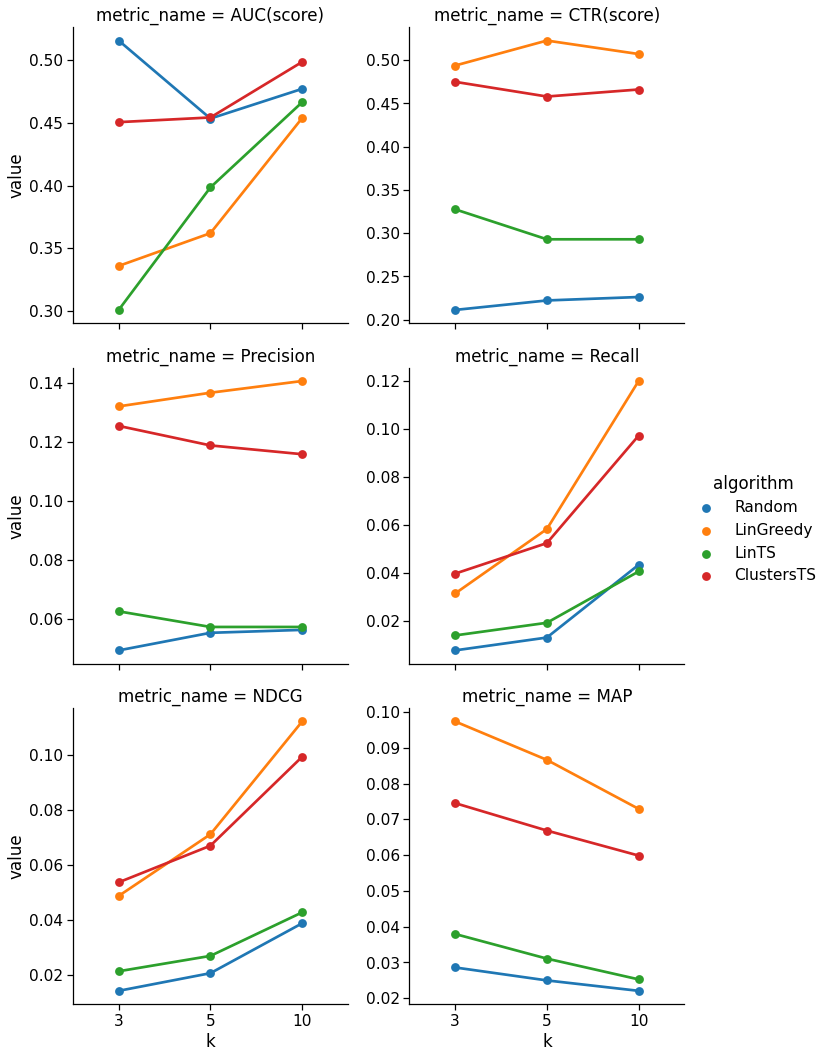

In [6]:
from mab2rec.visualization import plot_metrics_at_k

# Plot each metric across all algorithms at different k
plot_metrics_at_k(reco_to_metrics, col_wrap=2);

## Inter-list Diversity Metric

* Here we evaluate `Inter-list Diversity` for each algorithm. 
* The metric shows **how diverse recommendations are between users**. 
* A low value suggests that many users are receiving the same or similar recommendations. 
* A high value suggests that users are receiving different or diverse recommendations.
* As expected, the diversity of random recommendation is very high.

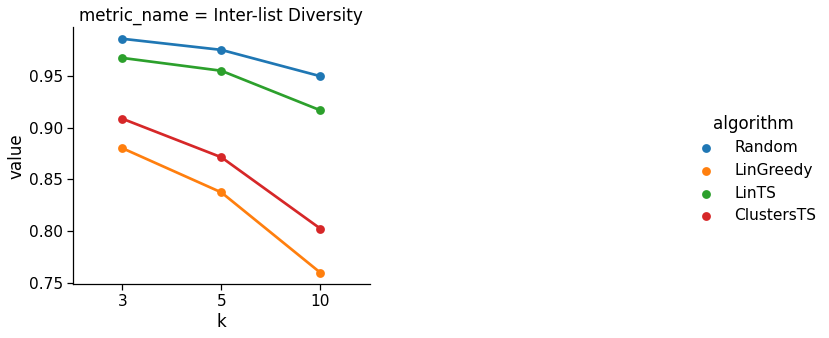

In [7]:
from mab2rec.visualization import plot_inter_diversity_at_k

# Plot diversity at each k for each algorithm
plot_inter_diversity_at_k(reco_to_results, k_list=[3, 5, 10], col_wrap=2);

## Intra-list Diversity Metric

* The `Intra-list diversity` metric measures the **diversity of items within each recommendation**, at different levels of $k$. 
* The similarity between different items are calculated based on the item features/embeddings. 
* A low value for this metric suggests that the items included in the top-$k$ recommendation are very similar.
* Again we observe highest diversity from random recommendation.

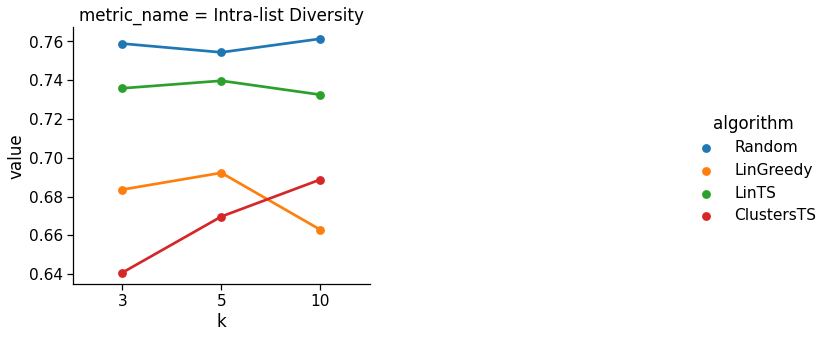

In [8]:
from mab2rec.visualization import plot_intra_diversity_at_k

# Plot diversity at each k for each algorithm
plot_intra_diversity_at_k(reco_to_results, item_features_df, k_list=[3, 5, 10], col_wrap=2);

## Recommendation Counts vs. Ground Truth 

* In these scatter plots each dot represents an item. 
* The plot shows the number of times the item was recommended (y-axis) vs. number of times the item occured (x-axis) in the test data.
* Notice that `LinGreedy` recommends a few items much more frequently.
* Items above the red line were recommended more often than it occurred in the test data, whereas items below the red line were recommended less often.

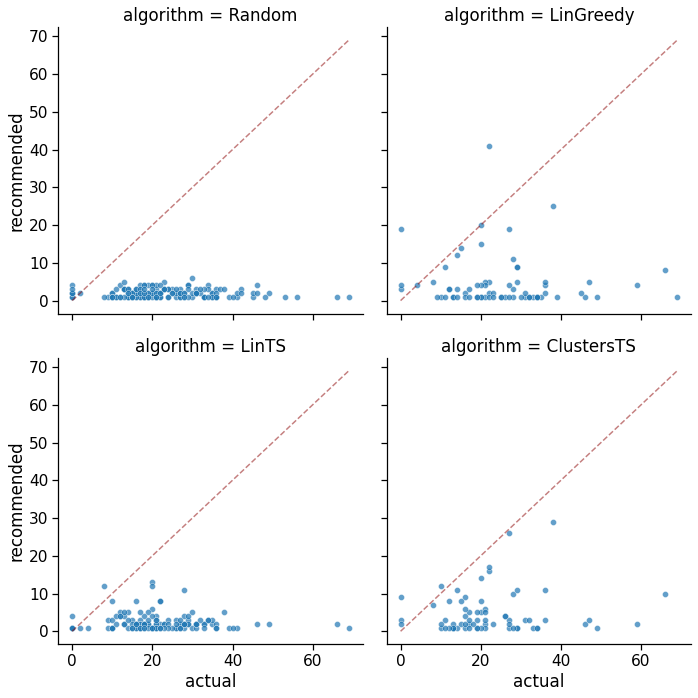

In [9]:
from mab2rec.visualization import plot_recommended_counts

# Plot recommendation counts (average=False)
plot_recommended_counts(reco_to_results, test_df, k=3, alpha=0.7, average_response=False, col_wrap=2);

* Next we look at the scatter plots that shows the number of times the item was recommended (y-axis) in the test data and the average response for that item (x-axis) the test data.
* As expected, recommendation counts for `Random` quite uniform and have no association with average ground truth responses.
* For `LinGreedy` and `ClustersTS` there appears to be a positive association between recommendation counts and the average ground truth response for the other algorithms.

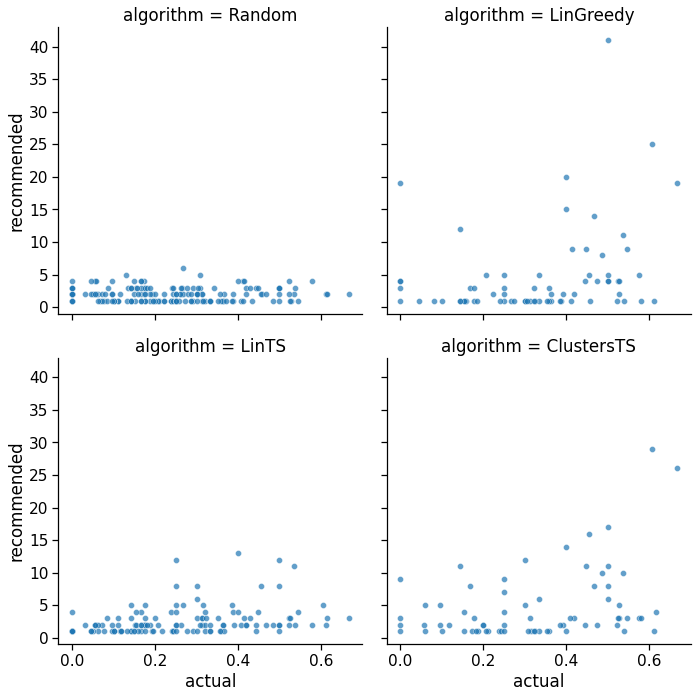

In [10]:
from mab2rec.visualization import plot_recommended_counts

# Plot recommendation counts (average = True)
plot_recommended_counts(reco_to_results, test_df, k=3, alpha=0.7, average_response=True, col_wrap=2);

## Recommendation Counts by Item

* These plots show the proportion (when normalize=True) of recommendations (y-axis) allocated to each item (x-axis) for the different algorithms.
* The `top_n_items` parameter controls the number of items in the x-axis. This is helpful when the number of items is too large to display.
* As expected, we see that the random baseline recommends each item at the same frequency.
* In contrast we note that `LinGreedy` appears to be exploiting a few items more, with the most recommended item included in ~12% of recommendations.

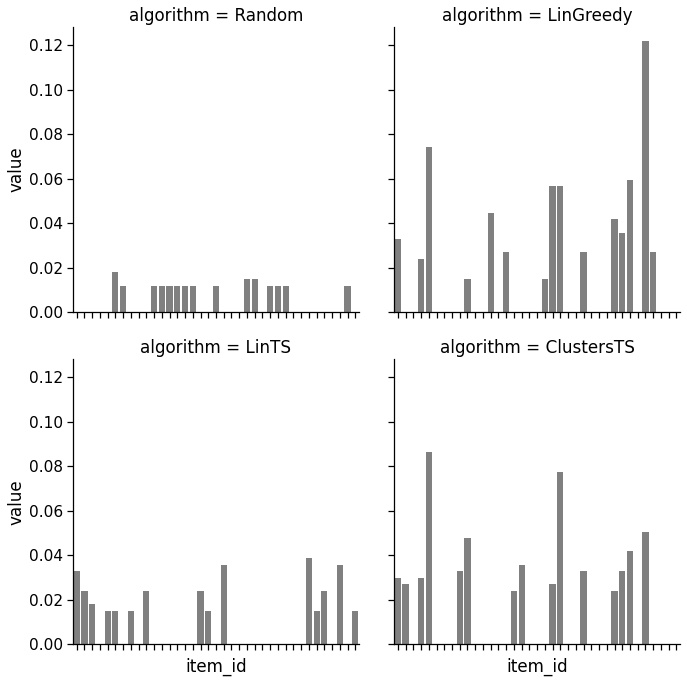

In [11]:
from mab2rec.visualization import plot_recommended_counts_by_item

# Plot recommendation counts (normalize=True)
plot_recommended_counts_by_item(reco_to_results, k=3, top_n_items=15, normalize=True, col_wrap=2);

## Personalization Heatmap

* The heatmaps show how the distribution of recommended items compare between different user clusters.
* User clusters are inferred from the user features using a clustering method such as `KMeans`.
* An algorithm with limited personalization will show similar patterns across different clusters.
* We notice the most variation across different clusters (see horizontal bars) for `LinGreedy` and `ClustersTS`. 
* This  indicates that some items are recommended more/less frequently depending on the user context, i.e., personalization in effect.
* As expected, almost no variation (no personalization) for `Random`.

In [12]:
from sklearn.cluster import KMeans

# Create clusters based on user features
X = user_features_df.iloc[:, 1:]

kmeans = KMeans(n_clusters=5, random_state=1652)
kmeans.fit(X)

user_clusters = dict(zip(user_features_df['user_id'], kmeans.labels_))

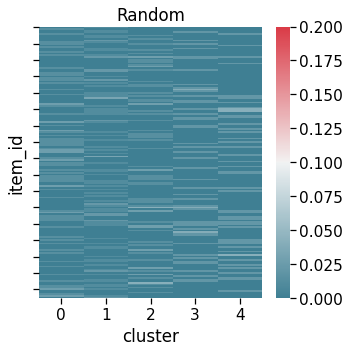

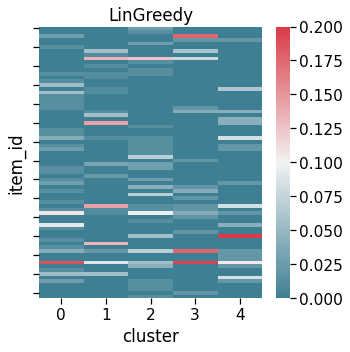

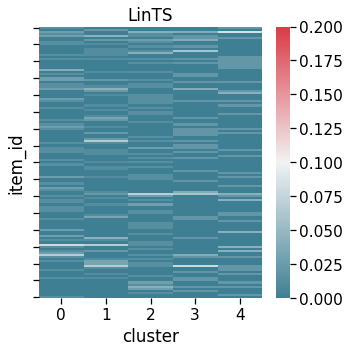

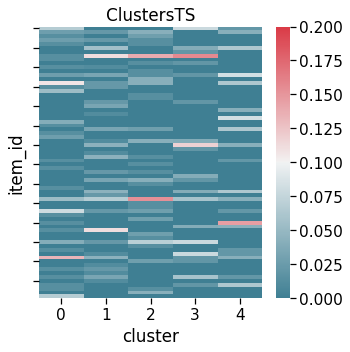

In [13]:
from mab2rec.visualization import plot_personalization_heatmap
plot_personalization_heatmap(reco_to_results, user_clusters, k=3, figsize=(5, 5), cmap=cmap, vmax=0.2);

## Fairness Metrics
* For a holistic evaluation, we are not only interested in performance results but also **fairness and bias metrics**. 
* Recommendation is a multi-class (several items) and multi-label (top-k recommendation) learning task. 
* Let's assume that we have a binary `protected_feature_name` and we want to evaluate fairness within the user population.
* We first find all predicions based on the `LinGreedy` algorithm. 
* Using the `is_member` relation based on the protected attribute, the predictions are evaluated via `MultiClassFairness` metrics such as **statistical parity** and **disparate impact**. 
* Finally, we compare the values found to their ideal ranges to uncover potential bias, if any.

In [14]:
from jurity.fairness import MultiClassFairnessMetrics

k = 3
protected_feature_name = "u5"

# Get top-k recommendations for selected algo
results = reco_to_results["LinGreedy"]
results = results.sort_values("score", ascending=False).groupby("user_id").head(k)

# Predicted items by user
predictions = results.groupby("user_id")["item_id"].apply(list)

# Unique items/classes
classes = results["item_id"].unique().tolist()

# Protected attribute 
is_member = user_features_df.set_index("user_id")[protected_feature_name]
is_member = is_member[predictions.index]

# Convert to lists
predictions = predictions.tolist()
is_member = is_member.tolist()

# Fairness metrics to evaluate
statistical_parity_metric = MultiClassFairnessMetrics.StatisticalParity(classes)
disparate_impact_metric = MultiClassFairnessMetrics.DisparateImpact(classes)

# Get scores for each metric
statistical_parity_scores = statistical_parity_metric.get_scores(predictions, is_member)
disparate_impact_scores = disparate_impact_metric.get_scores(predictions, is_member)

# Results 
print("Statistical Parity Results:")
print("Ideal Ranges: lb=", 
      statistical_parity_metric.lower_bound, " ideal=", 
      statistical_parity_metric.ideal_value, " ub=", 
      statistical_parity_metric.upper_bound)
print(statistical_parity_scores[0:5])

print("\nDisparate Impact Results:")
print("Ideal Ranges: lb=", 
      disparate_impact_metric.lower_bound, " ideal", 
      disparate_impact_metric.ideal_value, " ub=", 
      disparate_impact_metric.upper_bound)
print(disparate_impact_scores[0:5])


Statistical Parity Results:
Ideal Ranges: lb= -0.2  ideal= 0  ub= 0.2
[-0.01020408163265306, -0.25510204081632654, -0.04081632653061226, -0.01020408163265306, 0.47959183673469385]

Disparate Impact Results:
Ideal Ranges: lb= 0.8  ideal 1  ub= 1.2
[0.0, 0.0, 0.7777777777777777, 0.0, 24.500000000000004]


# Train & Export

* Finally, we can train and export the "best" algorithm based on the evaluations performed.
* Below we first train the `LinGreedy` algorithm on the train data.
* In practice, we would use both the training and test data for training at this point.
* We also serialize (save) the trained recommender to a pickle file (see [Advanced](https://github.com/fidelity/mab2rec/notebooks/5_advanced.ipynb) notebook for more details on model persistency).
* Lastly, we use the trained recommender to score recommendations, confirming that training was successful.

In [15]:
from mab2rec import BanditRecommender, LearningPolicy
from mab2rec.pipeline import train, score

# LinGreedy recommender to select top-4 items with 10% random exploration 
rec = BanditRecommender(LearningPolicy.LinGreedy(epsilon=0.1), top_k=4)

# Train on (user, item, response) interactions in train data using user features 
rec_pickle = os.path.join(tmp_dir, 'rec.pkl')
train(recommender=rec, 
      data='data/data_train.csv', 
      user_features='data/features_user.csv',
      save_file=rec_pickle)

# Score recommendations for users in test data. The output df holds 
# user_id, item_id, score columns for every test user for top-k items 
df = score(recommender=rec_pickle, 
           data='data/data_test.csv', 
           user_features='data/features_user.csv')

df.head()

,user_id,item_id,score
0,259,483,0.672446
1,259,474,0.656253
2,259,12,0.651795
3,259,64,0.650715
4,851,313,0.701218


* Alternatively, the steps above could also be executed from **command line** as follows.

In [16]:
# Train LinGreedy recommender based on configuration in scripts/train.yaml
!python scripts/train.py --config scripts/train.yaml

# Score using configuration in scripts/score.yaml
!python scripts/score.py --config scripts/score.yaml

# Read scored recommendations
df = pd.read_csv(os.path.join(tmp_dir, 'results.csv'))
df.head()

,user_id,item_id,score
0,259,483,0.672446
1,259,474,0.656253
2,259,12,0.651795
3,259,64,0.650715
4,259,357,0.643506


In [17]:
# Clean up
shutil.rmtree(tmp_dir)